# 캐글 자전거 수요 예측 프로젝트
코드잇 데이터분석 스프린트 미션 14번째 주제 : 공유자전거 대여 수요 예측
## 1. 분석 주제 : 
워싱턴DC의 공유자전거 수요를 예측
## 2. 분석 목표 : 
날씨, 날짜, 풍속, 습도 등 다양한 변수를 통해 자전거 대여 수를 예측하여 가장 높은 RMSLE 값을 산출
## 3. 분석 데이터셋 :
### 3-1. 데이터 컬럼 설명
| 컬럼명      | 데이터 타입 | 데이터 설명                                                                 |
|-------------|--------------|------------------------------------------------------------------------------|
| datetime    | datetime     | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00                  |
| season      | int          | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)                                    |
| holiday     | int          | 공휴일 여부 (0: 평일, 1: 공휴일)                                           |
| workingday  | int          | 근무일 여부 (0: 주말/공휴일, 1: 근무일)                                     |
| weather     | int          | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)          |
| temp        | float        | 실측 온도 (섭씨)                                                           |
| atemp       | float        | 체감 온도 (섭씨)                                                           |
| humidity    | int          | 습도 (%)                                                                   |
| windspeed   | float        | 풍속 (m/s)                                                                 |
| casual      | int          | 등록되지 않은 사용자의 대여 수                                             |
| registered  | int          | 등록된 사용자의 대여 수                                                   |
| count       | int          | 총 대여 수 (종속 변수)                                                    |
## 4. 분석 방법 :
- 전체적인 분석은 회귀분석을 진행
- k-fold 모델 교차 검증을 통해 검증 정확도를 향상
- 하이퍼 파라미터 튜닝을 통해 최적의 파라미터 값을 도출
## 5. 분석 결과 : 최종 RMSLE값은 약 0.3208 도출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 1. 데이터 불러오기

| 컬럼명     | 데이터 타입 | 설명 |
|-----------|------------|----------------------------------------------------|
| datetime  | datetime   | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00 |
| season    | int        | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울) |
| holiday   | int        | 공휴일 여부 (0: 평일, 1: 공휴일) |
| workingday| int        | 근무일 여부 (0: 주말/공휴일, 1: 근무일) |
| weather   | int        | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| temp      | float      | 실측 온도 (섭씨) |
| atemp     | float      | 체감 온도 (섭씨) |
| humidity  | int        | 습도 (%) |
| windspeed | float      | 풍속 (m/s) |
| casual    | int        | 등록되지 않은 사용자의 대여 수 |
| registered| int        | 등록된 사용자의 대여 수 |
| count     | int        | 총 대여 수 (종속 변수) |


In [2]:
# train data
train_df = pd.read_csv("data/train.csv")

# test data
test_df = pd.read_csv("data/test.csv")

In [3]:
display(train_df)
display(test_df)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


# 2. 데이터 확인하기

## 2.1 기술통계량 확인

In [4]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 2.2 중복값 확인하기 

In [6]:
train_df.duplicated().sum()

0

## 2.3 결측치 확인하기 

In [7]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## 2.4 데이터 분포 확인하기

### 1) 범주형 데이터 고유값 수 확인하기

In [8]:
# 확인할 컬럼 리스트
check_col = ['season', 'holiday', 'workingday', 'weather']

# for문으로 확인하기
for c in train_df[check_col]:
    print(f"{c}피쳐 데이터 수: \n{train_df[c].value_counts()}")

season피쳐 데이터 수: 
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
holiday피쳐 데이터 수: 
0    10575
1      311
Name: holiday, dtype: int64
workingday피쳐 데이터 수: 
1    7412
0    3474
Name: workingday, dtype: int64
weather피쳐 데이터 수: 
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


In [9]:
# for문으로 확인하기
for c in test_df[check_col]:
    print(f"{c}피쳐 데이터 수: \n{test_df[c].value_counts()}")

season피쳐 데이터 수: 
3    1763
2    1676
1    1556
4    1498
Name: season, dtype: int64
holiday피쳐 데이터 수: 
0    6304
1     189
Name: holiday, dtype: int64
workingday피쳐 데이터 수: 
1    4453
0    2040
Name: workingday, dtype: int64
weather피쳐 데이터 수: 
1    4221
2    1710
3     560
4       2
Name: weather, dtype: int64


### 범주형 데이터 고유값 수 확인 결과
#### 1. season
대체적으로 고르게 분포
#### 2. holiday
공휴일이 아닌 날이 많음
#### 3. workingday
일하는날에 많이 대여함
#### 4. weather
날씨가 좋은날에 많이 타며, 폭우/폭설에 대여량 한건 존재함

### 2) 히스토그램 그리기

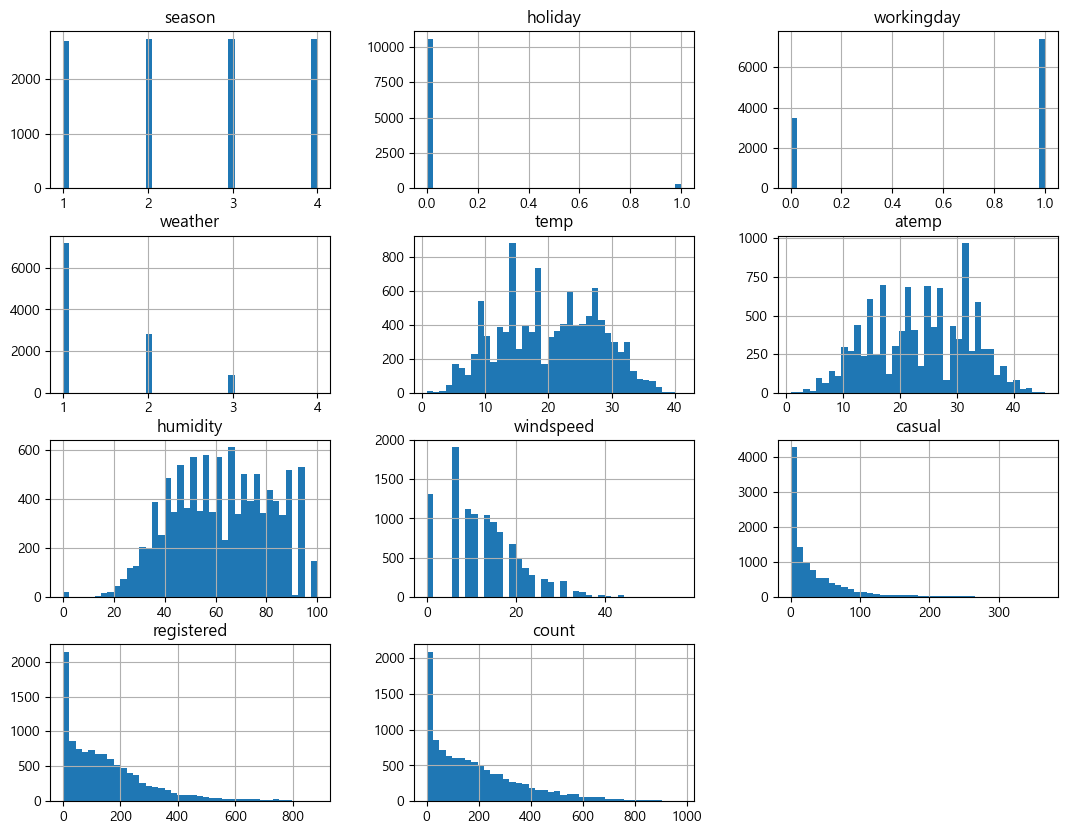

In [10]:
# 히스토그램 그리기
train_df.hist(bins=40, figsize=(13, 10))
plt.show()

### 데이터 분포(히스토그램) 확인 결과
#### 1. 계절
계절의 데이터는 대체적으로 고르게 분포
#### 2. 공휴일 여부
대부분 평일에 대여
#### 3. 근무일 여부
근무하는 날에 대여량이 더 많음
#### 4. 날씨의 상태
날씨가 좋을수록 많이 빌리고, 안좋을수록 적게 빌림
#### 5. 실측 온도(섭씨)
정규분표 형태와 비슷한 형상을 보여줌. 날씨가 좋을 때 대여량이 높음
#### 6. 체감 온도(섭씨)
정규분표 형태와 비슷한 형상을 보여줌. 날씨가 좋을 때 대여량이 높음
#### 7. 습도 (%)
정규분포 형태와 비슷한 형상을 보여줌, 왼쪽으로 꼬리가 긴 형태로 보여줌, 즉 습도가 높은쪽에 데이터가 더 많이 분포됨
#### 8. 풍속 (m/s)
풍속이 낮을 때 대여량이 높음


### 3) 수치형 데이터 box-plot 확인하기

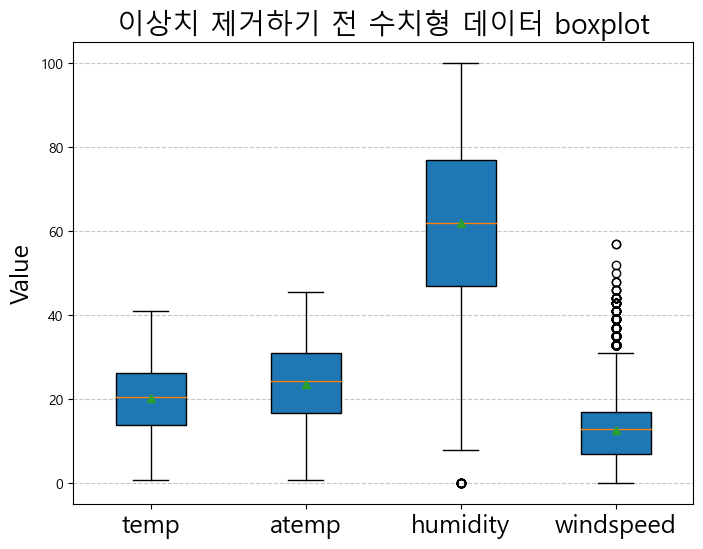

In [11]:
# 컬럼 리스트
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed']

# 박스플롯 그리기
plt.figure(figsize=(8, 6))  # 그래프 크기 조정
plt.boxplot([train_df[col] for col in numeric_columns], labels=numeric_columns, patch_artist=True, showmeans=True)

# 제목 및 축 레이블 추가
plt.title("이상치 제거하기 전 수치형 데이터 boxplot", fontsize=20)
plt.ylabel("Value", fontsize=18)

plt.xticks(fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 가로줄 추가

# 그래프 보이기
plt.show()

## 2.5 날짜와 시간대에 따른 대여량 확인

### 1) datetime 형태 변환

In [12]:
# datetime 컬럼의 형태를 datetime 형태로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# datetime 컬럼에서 연도 데이터를 year 컬럼으로 저장
train_df['year'] = train_df['datetime'].dt.year
test_df['year'] = test_df['datetime'].dt.year

# datetime 컬럼에서 요일 컬럼을 date 컬럼으로 저장
train_df['date'] = train_df['datetime'].dt.dayofweek
test_df['date'] = test_df['datetime'].dt.dayofweek

# datetime 컬럼에서 월 데이터를 month 컬럼으로 저장
train_df['month'] = train_df['datetime'].dt.month
test_df['month'] = test_df['datetime'].dt.month

# datetime 컬럼에서 시간 데이터를 hour 컬럼으로 저장
train_df['hour'] = train_df['datetime'].dt.hour
test_df['hour'] = test_df['datetime'].dt.hour

# hour컬럼으로 저장되었는지 확인
train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,date,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,5,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,5,1,2


### 2) 연도별, 월별, 요일별, 시간대별 자전거 대여량 수 시각화

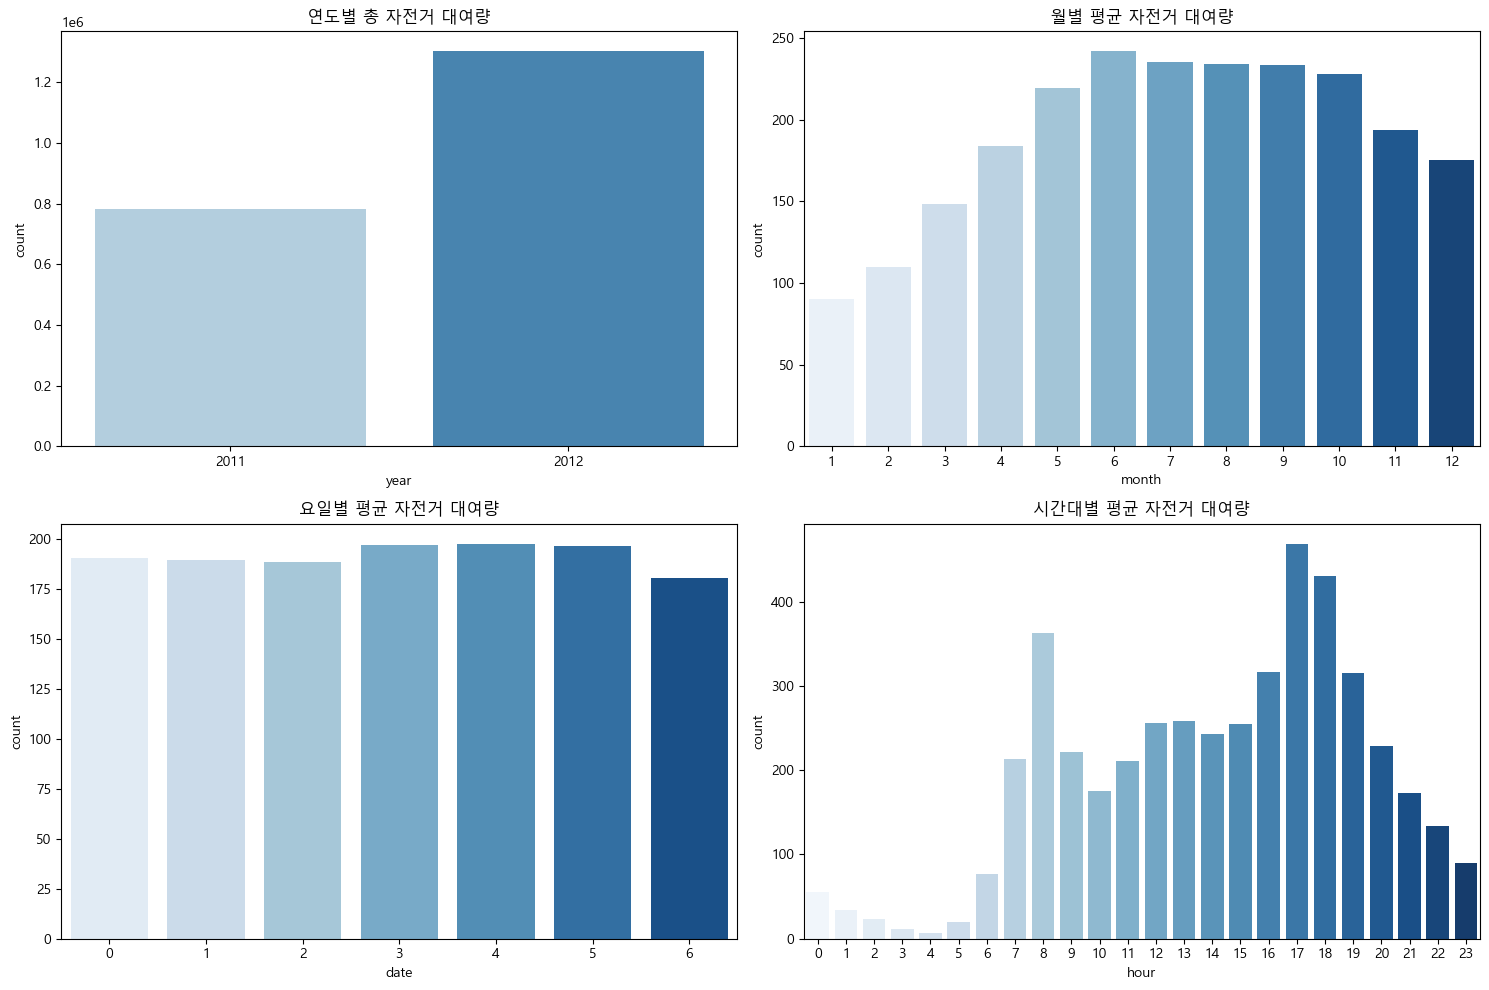

In [13]:
# 데이터 그룹화
bicycle_count_by_year = train_df.groupby('year')['count'].sum().reset_index()
bicycle_count_by_month = train_df.groupby('month')['count'].mean().reset_index()
bicycle_count_by_date = train_df.groupby('date')['count'].mean().reset_index()
bicycle_count_by_hour = train_df.groupby('hour')['count'].mean().reset_index()

# 서브플롯 생성 (2행 2열)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 연도별 총 대여량 (좌측 상단)
sns.barplot(x=bicycle_count_by_year['year'], y=bicycle_count_by_year['count'], ax=ax[0, 0], palette='Blues')
ax[0, 0].set(title='연도별 총 자전거 대여량')

# 월별 평균 대여량 (우측 상단)
sns.barplot(x=bicycle_count_by_month['month'], y=bicycle_count_by_month['count'], ax=ax[0, 1], palette='Blues')
ax[0, 1].set(title='월별 평균 자전거 대여량')

# 요일별 평균 대여량 (좌측 하단)
sns.barplot(x=bicycle_count_by_date['date'], y=bicycle_count_by_date['count'], ax=ax[1, 0], palette='Blues')
ax[1, 0].set(title='요일별 평균 자전거 대여량')

# 시간대별 평균 대여량 (우측 하단)
sns.barplot(x=bicycle_count_by_hour['hour'], y=bicycle_count_by_hour['count'], ax=ax[1, 1], palette='Blues')
ax[1, 1].set(title='시간대별 평균 자전거 대여량')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()


### 3) 결과 해석
### 연도별
- **2012년**에 대여량이 많음
### 월별

- **1월~3월**
    - 날씨가 추운 겨울에는 이용량이 낮음
- **4월~10월**
    - 날씨가 좋은 봄~가을까지 이욜량이 높음
- **11월~12월**
    - 다시 추워지기 시작하는 겨울에는 이용량이 감소함

### 요일대별
- **전체적으로 대여량이 다 높음**


### 시간대별

- **0시~6시**
    - 밤~새벽 시간대, 대여량 매우 낮음
- **7시~8시**
    - 출근 시간대, 대여량 증가
- **9시~16시**
    - 일과 시간대, 대여량 높지 않음
- **17시~19시**
    - 퇴근 시간대, 대여량 매우 높음
- **20시~23시**
    - 퇴근 시간대 이후, 대여량 감소

# 3. 데이터 전처리

## 3.1 이상치 제거
### 1) 예측모델의 정확도 향상을 위해 변수의 이상치를 제거

In [14]:
# 원본 데이터 복사
train_clean = train_df.copy()

# 이상치 제거할 컬럼
outlier_remove_col = ['temp', 'atemp', 'humidity', 'windspeed']

# 이상치 제거 함수
def remove_outliers(df, columns):
    for col in columns: 
        Q1 = df[col].quantile(0.25) 
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 기준
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 데이터 재분류
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

### 2) 이상치 제거 전/후 데이터 개수 비교

In [15]:
# 이상치 제거 전 데이터 크기
print(f"이상치 제거 전 데이터의 개수 : {len(train_df)}개")

# 이상치 제거 후 크기
cleaned_train_df = remove_outliers(train_clean, outlier_remove_col)

print(f"이상치 제거 후 데이터의 개수 : {len(cleaned_train_df)}개")

# 제거된 데이터 수
print(f"제거된 데이터의 개수 : {len(train_df) - len(cleaned_train_df)}개")

이상치 제거 전 데이터의 개수 : 10886개
이상치 제거 후 데이터의 개수 : 10638개
제거된 데이터의 개수 : 248개


### 3) 박스플롯 시각화 확인

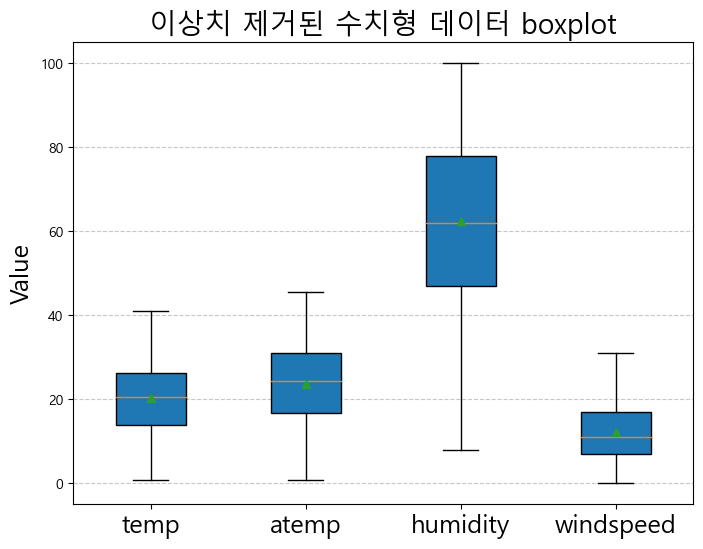

In [16]:
# 박스플롯 그리기
plt.figure(figsize=(8, 6))  # 그래프 크기 조정
plt.boxplot([cleaned_train_df[col] for col in numeric_columns], labels=numeric_columns, patch_artist=True, showmeans=True)

# 제목 및 축 레이블 추가
plt.title("이상치 제거된 수치형 데이터 boxplot", fontsize=20)
plt.ylabel("Value", fontsize=18)
plt.xticks(fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 가로줄 추가

# 그래프 보이기
plt.show()

## 3.2 이상치 대체
### 1) windspeed 컬럼 이상치
windspeed 컬럼의 데이터 분포를 확인해본 결과 풍속이 0으로 표현된 경우가 다수 존재하므로, 풍속이 0인 경우 train데이터의 최소값으로 데이터를 채워준다. 

In [17]:
cleaned_train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,date,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,5,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,5,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,5,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,5,1,4


In [18]:
# windspeed 컬럼 0값의 개수 확인
windspeed_0_count = len(cleaned_train_df[cleaned_train_df['windspeed'] == 0])

print(f"windspeed 0인 데이터 수 : {windspeed_0_count}개")

# windspeed 0 다음의 최소값 확인
next_min_windspeed = cleaned_train_df[cleaned_train_df['windspeed'] > 0].min()['windspeed']

print(f"windspeed 0 다음의 최소값 : {next_min_windspeed}m/s")

windspeed 0인 데이터 수 : 1313개
windspeed 0 다음의 최소값 : 6.0032m/s


풍속이 0인 지점을 6.0032으로 입력해준다.

In [19]:
# 풍속이 0인 지점을 6.0032 값으로 대체
cleaned_train_df.loc[cleaned_train_df['windspeed'] == 0, 'windspeed'] = 6.0032

In [20]:
print(f"windspeed 0인 데이터 수 : {len(cleaned_train_df[cleaned_train_df['windspeed'] == 0])}개")

windspeed 0인 데이터 수 : 0개


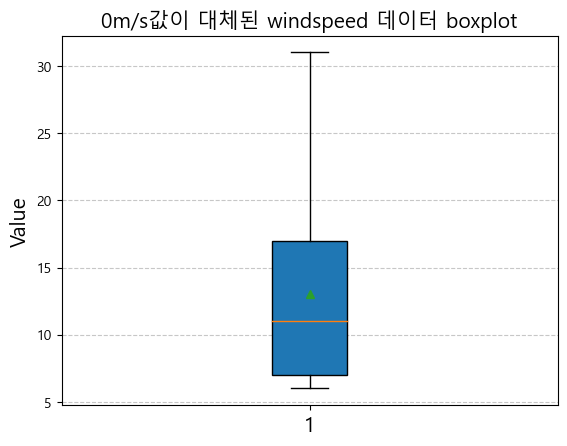

In [21]:
plt.boxplot(cleaned_train_df['windspeed'], patch_artist=True, showmeans=True)
plt.title("0m/s값이 대체된 windspeed 데이터 boxplot", fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.xticks(fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 가로줄 추가

# 4. 피쳐 엔지니어링
### 분산팽창지수
변수가 여러개인 데이터에서 회귀분석을 진행할 때 각 변수가 서로 영향을 줘서 분석 정확도가 떨어지거나,
<br>데이터가 너무 잘 맞는 과대적합의 문제가 발생할 수 있다.
<br>각 변수들의 관계를 파악하기 위해 **분산팽창지수(VIF)** 를 확인하여, 어떤 변수가 다중공선성 문제를 갖고있는지 확인한다.
<BR>분산팽창지수는 10을 넘어가는 경우 다중공선성 문제가 있다고 판단하며, 해당 변수들을 전처리하는 과정을 거쳐야 한다.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF확인용으로 datetime컬럼 삭제
X_VIF = cleaned_train_df.copy()

X_VIF.drop(columns='datetime', inplace=True)

# 분산팽창지수를 입력할 빈 데이터프레임 생성
vif_data = pd.DataFrame()

# 변수들의 컬럼명을 전부 입력
vif_data['Variables'] = X_VIF.columns

# 각 변수의 분산팽창지수 계산하여 VIF컬럼에 입력
vif_data['VIF'] = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]

# 분산팽창지수 확인
vif_data

C:\Users\gkdis\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variables,VIF
0,season,111.148432
1,holiday,1.579266
2,workingday,10.048791
3,weather,7.753730
4,temp,277.867247
5,atemp,318.511006
6,humidity,20.919076
7,windspeed,6.052064
8,casual,inf
9,registered,inf


### 분산팽창지수 확인 결과
- 대부분의 변수의 분산팽창지수가 10을 초과함
- VIF가 10을 넘어가는 변수들을 피쳐엔지니어링 통해 최대한 VIF값을 낮추도록 한다.

## 4.1 상관관계 시각화
### 1) 히트맵 시각화 진행
#### 각 변수들의 상관관계를 확인하기 위해 히트맵 시각화 진행
- 상관계수에 절대값 적용을 통해 상관성이 얼마나 강한지 확인한다.

C:\Users\gkdis\AppData\Local\Temp\ipykernel_22136\1306038506.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abs(cleaned_train_df.corr()), annot=True, cmap='Blues')


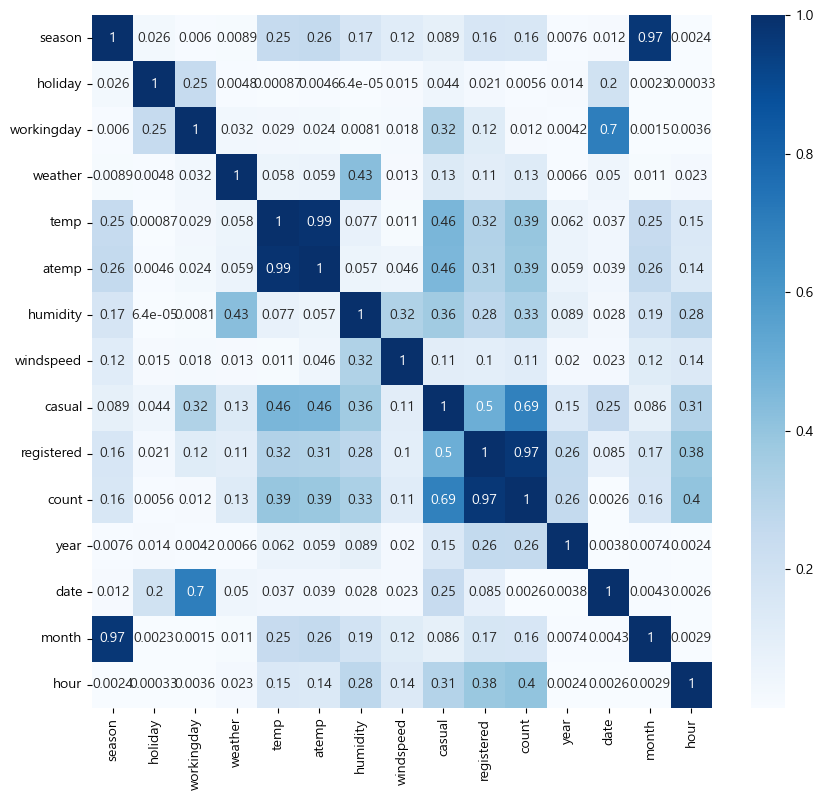

In [23]:
# 히트맵 시각화 진행
plt.figure(figsize=(10,9))
# 양의 상관성, 음의 상관성 관계 없이 얼마나 상관성이 많이 존재하는지 확인해보기 위해 절대값으로 확인
sns.heatmap(abs(cleaned_train_df.corr()), annot=True, cmap='Blues')
plt.show()

### 2) season, month 상관계수 0.97

In [24]:
# season과 month별로 pivot table 생성하여 확인하기
pd.pivot_table(cleaned_train_df, index=['season', 'month'])

C:\Users\gkdis\AppData\Local\Temp\ipykernel_22136\758931984.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pd.pivot_table(cleaned_train_df, index=['season', 'month'])


atemp     casual       count      date   holiday       hour  \
season month                                                                    
1      1      12.102632   8.233294   90.082063  2.953107  0.082063  11.737397   
       2      14.519982  10.092090  110.330579  3.126328  0.000000  11.436836   
       3      19.026882  28.502959  148.776331  3.061538  0.000000  11.465089   
2      4      22.175540  43.725287  184.258621  3.025287  0.054023  11.419540   
       5      26.624313  45.254707  219.091916  2.929125  0.000000  11.485050   
       6      30.979467  53.193119  240.391787  3.175361  0.000000  11.489456   
3      7      34.886564  55.580110  234.197790  2.948066  0.053039  11.462983   
       8      33.109237  50.038717  233.545354  2.982301  0.000000  11.460177   
       9      29.572191  50.353726  232.984427  3.066741  0.052280  11.525028   
4      10     24.711885  41.025499  225.874723  2.838137  0.053215  11.488914   
       11     18.311390  27.674419  193.537099  3.073090  0.049834  11.514950   
       12     17.108499  16.129139  176.019868  3.059603  0.000000  11.464680   

               humidity  registered       temp   weather  windspeed  \
season month                                                          
1      1      56.379836   81.848769   9.799625  1.409144  14.348887   
       2      57.641086  100.238489  11.709445  1.478158  13.255875   
       3      58.671006  120.273373  15.882769  1.373964  14.941468   
2      4      55.886207  140.533333  18.574414  1.425287  15.185612   
       5      68.230343  173.837209  22.663965  1.524917  12.787866   
       6      58.983352  187.198668  27.050899  1.310766  12.658732   
3      7      58.413260  178.617680  30.832906  1.246409  11.539836   
       8      62.997788  183.506637  29.730442  1.346239  12.461941   
       9      70.968854  182.630701  25.762047  1.488320  12.112027   
4      10     69.544346  184.849224  20.910909  1.524390  12.078533   
       11     60.866002  165.862680  15.170454  1.356589  13.608709   
       12     68.398455  159.890728  13.815099  1.487859  11.616964   

              workingday         year  
season month                           
1      1        0.614302  2011.501758  
       2        0.721370  2011.520661  
       3        0.702959  2011.512426  
2      4        0.650575  2011.508046  
       5        0.734219  2011.501661  
       6        0.680355  2011.498335  
3      7        0.658564  2011.499448  
       8        0.740044  2011.502212  
       9        0.630701  2011.498331  
4      10       0.685144  2011.501109  
       11       0.658915  2011.500554  
       12       0.682119  2011.501104

1. season 1은 1,2,3월이 포함됨
2. season 2는 4,5,6월이 포함됨
3. season 3은 7,8,9월이 포함됨
4. season 4는 10,11,12월이 포함됨

따라서 `season`컬럼을 삭제 및 **`month`컬럼으로 `season`컬럼을 대체**

### 3) atemp, temp 상관계수 0.99
체감온도와, 실제온도는 매우 비슷한 값이 측정된 수치로 두 컬럼의 상관계수가 높게 형성됨
</br>atemp와 temp 컬럼 중 1개의 컬럼을 삭제하거나, 주성분 분석을 진행하여 두 컬럼을 하나의 성분으로 변환

#### PCA(주성분 분석) 진행
atemp, temp 컬럼의 주성분 분석을 통해서 하나의 컬럼으로 변환작업 진행

In [25]:
from sklearn.preprocessing import StandardScaler

# 표준화 함수 정의
scaler = StandardScaler()

# 데이터 복사
feature_scaling_df = cleaned_train_df.copy()
feature_scaling_df_test = test_df.copy()

scaled_temp = scaler.fit_transform(feature_scaling_df[['atemp', 'temp']])
scaled_temp_test = scaler.fit_transform(feature_scaling_df_test[['atemp', 'temp']])

# scaled_temp
feature_scaling_df['scaled_atemp'] = scaled_temp[:, 0]
feature_scaling_df['scaled_temp'] = scaled_temp[:, 1]

feature_scaling_df_test['scaled_atemp'] = scaled_temp_test[:, 0]
feature_scaling_df_test['scaled_temp'] = scaled_temp_test[:, 1]

feature_scaling_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,date,month,hour,scaled_atemp,scaled_temp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.0032,3,13,16,2011,5,1,0,-1.104098,-1.339360
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.0032,8,32,40,2011,5,1,1,-1.194059,-1.444583
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.0032,5,27,32,2011,5,1,2,-1.194059,-1.444583
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.0032,3,10,13,2011,5,1,3,-1.104098,-1.339360
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.0032,0,1,1,2011,5,1,4,-1.104098,-1.339360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,2,12,19,-0.476741,-0.602800
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,2,12,20,-0.745439,-0.708023
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,2,12,21,-0.924769,-0.813246
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,2,12,22,-0.745439,-0.813246


In [26]:
from sklearn.decomposition import PCA

# 주성분 분석을 진행할 컬럼만 데이터프레임으로 변경
temp_df = feature_scaling_df[['scaled_temp', 'scaled_atemp']]
temp_df_test = feature_scaling_df_test[['scaled_temp', 'scaled_atemp']]


# 주성분분석 모델 설정(주성분은 1개)
pca = PCA(n_components=1, random_state=42)
pca2 = PCA(n_components=1, random_state=42)

# 주성분 변환 진행
temp_components = pca.fit_transform(temp_df[['scaled_temp', 'scaled_atemp']])
temp_components_test = pca.fit_transform(temp_df_test[['scaled_temp', 'scaled_atemp']])


# 주성분 값 적용
feature_scaling_df['temp_pca'] = temp_components
feature_scaling_df_test['temp_pca'] = temp_components_test


feature_scaling_df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,date,month,hour,scaled_atemp,scaled_temp,temp_pca
5356,2011-12-17 06:00:00,4,0,0,2,10.66,12.120,56,19.0012,0,17,17,2011,5,12,6,-1.373388,-1.234137,1.843799
8852,2012-08-11 05:00:00,3,0,0,1,25.42,28.030,88,7.0015,2,9,11,2012,5,8,5,0.509867,0.659873,-0.827131
7186,2012-04-17 19:00:00,2,0,1,1,24.60,30.305,26,16.9979,73,464,537,2012,1,4,19,0.779157,0.554650,-0.943144
92,2011-01-05 00:00:00,1,0,1,1,8.20,12.880,64,6.0032,0,6,6,2011,2,1,0,-1.283428,-1.549805,2.003398
10584,2012-12-07 10:00:00,4,0,1,2,13.12,15.910,76,11.0014,16,150,166,2012,4,12,10,-0.924769,-0.918469,1.303366


In [27]:
# pca의 주성분 벡터의 계수 확인
print(pca.components_)

[[0.70710678 0.70710678]]


In [28]:
# 생성된 주성분의 분산비율 확인
pca.explained_variance_ratio_

array([0.99596813])

#### temp와 atemp 데이터의 값이 클수록 temp_pca의 값은 낮아지는 이유
- pca의 가중치 값은 **-0.6775837**, **-0.73544567** 으로 전부 음수이다.
- 음수 벡터 계수에 의하여 높은 `temp`와 `atemp` 값은 `temp_pca`에서 음의 영향을 받음

## 4.2 연속형 데이터 피쳐 스케일링

연속형(수치형) 데이터의 범위를 맞춰주기 위해 데이터 스케일링을 진행한다.
<bR>데이터의 퍼진 정도가 크지 않으므로, 정규화 방법을 사용하여 피쳐 스케일링 진행
   


In [29]:
from sklearn.preprocessing import MinMaxScaler

# 피쳐 스케일링 진행할 컬럼을 데이터프레임으로 받기
not_scaled_df = feature_scaling_df[['humidity', 'windspeed']]
not_scaled_df_test = feature_scaling_df_test[['humidity', 'windspeed']]

# 정규화 함수 인스턴스로 선언
minmax_scaler = MinMaxScaler()

# 정규화 적용
scaled_data = minmax_scaler.fit_transform(not_scaled_df)
scaled_data_test = minmax_scaler.fit_transform(not_scaled_df_test)

# 정규화된 값을 원본 데이터에 저장
feature_scaling_df[['humidity', 'windspeed']] = scaled_data
feature_scaling_df_test[['humidity', 'windspeed']] = scaled_data_test

feature_scaling_df.sample(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,date,month,hour,scaled_atemp,scaled_temp,temp_pca
6554,2012-03-10 08:00:00,1,0,0,1,9.02,10.605,0.391304,0.559904,15,96,111,2012,5,3,8,-1.552718,-1.444583,2.119411
7800,2012-06-05 09:00:00,2,0,1,2,21.32,25.000,0.695652,0.439828,50,285,335,2012,1,6,9,0.151208,0.133759,-0.201502
1542,2011-04-10 03:00:00,2,0,0,2,15.58,19.695,0.858696,0.119807,5,11,16,2011,6,4,3,-0.476741,-0.602800,0.763351


## 4.3 범주형 데이터 변환

In [30]:
# season, weather 데이터 확인
feature_scaling_df[['season', 'weather', 'workingday', 'holiday', 'hour', 'month']].sample(3)

,season,weather,workingday,holiday,hour,month
3022,3,1,1,0,20,7
8358,3,2,1,0,15,7
7306,2,1,1,0,19,5


- hour, month, season 컬럼의 경우 주기성을 나타내는 컬럼이므로 별다른 변환을 진행하지 않음
- 하지만 weather 피쳐의 경우 라벨 인코딩만 되어있는 상태
- weather 피쳐는 원-핫 인코딩 진행
- **다중공선성** 방지를 위해 불필요한 첫 번째 카테고리는 삭제를 진행

### 1) One-Hot Encoding 진행
- get_dummies() : 판다스 자체로 가능, 데이터프레임 바로 변환 가능
- OneHotEncoder() : sci-kit learn에서 불러오기, 넘파이 배열로 변환
- 데이터프레임 변환을 위해 **get_dummies()** 방식 사용

In [31]:
# 원-핫 인코딩 대상 컬럼
categorical_columns = ['weather']

# 원-핫 인코딩 진행, 다중공선성 방지를 위해 첫번째 데이터는 제거
encoded_train_df = pd.get_dummies(feature_scaling_df, columns=categorical_columns, drop_first=True)
encoded_test_df = pd.get_dummies(feature_scaling_df_test, columns=categorical_columns, drop_first=True)

In [32]:
# 인코딩 완료된 데이터 확인
encoded_train_df.sample(2)

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,...,year,date,month,hour,scaled_atemp,scaled_temp,temp_pca,weather_2,weather_3,weather_4
9892,2012-10-16 13:00:00,4,0,1,21.32,25.00,0.402174,0.519968,68,260,...,2012,1,10,13,0.151208,0.133759,-0.201502,0,0,0
10438,2012-12-01 08:00:00,4,0,0,9.84,12.12,0.858696,0.119807,11,133,...,2012,5,12,8,-1.373388,-1.339360,1.918203,1,0,0


# 5. 예측 모델 생성

## 5.1 독립변수 및 종속변수 구분

### 1) 불필요한 컬럼 제거
- `datetime` : hour, month 컬럼으로 변환 완료하여 삭제 진행
- `casual`, `registered` : 사용하지 않을 컬럼으로 삭제 진행
- `temp`, `atemp` : 주성분 분석을 통해 temp_pca 컬럼을 생성하여 삭제 진행
- `season` : month 컬럼과 강한 상관관계를 갖고 있으며, 해당 컬럼은 month 컬럼으로 대체

In [33]:
# 'season', 'datetime', 'casual', 'registered', 'scaled_atemp', 'scaled_temp', 'temp', 'atemp' 컬럼 삭제
encoded_train_df = encoded_train_df.drop(columns=['season', 'datetime', 'casual', 'registered', 'scaled_atemp', 'scaled_temp', 'temp', 'atemp'], axis=1)
display(encoded_train_df.sample(3))

encoded_test_df = encoded_test_df.drop(columns=['season', 'datetime', 'scaled_atemp', 'scaled_temp', 'temp', 'atemp'], axis=1)
display(encoded_test_df.sample(3))

,holiday,workingday,humidity,windspeed,count,year,date,month,hour,temp_pca,weather_2,weather_3,weather_4
4263,0,0,0.456522,0.119807,470,2011,6,10,16,-1.229548,0,0,0
5197,0,0,0.282609,0.719914,299,2011,5,12,15,1.292574,0,0,0
4941,0,1,0.565217,0.119807,59,2011,4,11,23,1.716994,0,0,0


,holiday,workingday,humidity,windspeed,year,date,month,hour,temp_pca,weather_2,weather_3,weather_4
479,0,0,0.321429,0.339316,2011,6,3,19,-1.105848,0,0,0
5937,0,1,0.500000,0.196458,2012,2,10,17,-0.656792,1,0,0
3638,0,0,0.702381,0.392917,2012,5,2,9,-2.158210,0,1,0


### 2) 독립변수 설정
데이터에서 종속변수(타겟변수)로 설정되는 count 값을 제외한 데이터만 사용한다.

In [34]:
# 종속변수인 count 컬럼 제거
X = encoded_train_df.drop(columns='count')
X.sample(3)

,holiday,workingday,humidity,windspeed,year,date,month,hour,temp_pca,weather_2,weather_3,weather_4
7275,0,1,0.815217,0.359957,2012,2,5,12,-0.615130,1,0,0
5092,0,1,0.934783,0.519968,2011,1,12,6,0.349723,1,0,0
1158,0,0,0.684783,0.000000,2011,5,3,22,0.900948,0,0,0


### 3) 독립변수 VIF, Heatmap 확인
피쳐엔지니어링 및 최종 독립변수로 선정된 변수들의 VIF값과 상관계수를 확인한다.

In [35]:
# vif 구하기
X_vif2 = X.copy()

vif_data2 = pd.DataFrame()
vif_data2['Variable'] = X_vif2.columns

vif_data2['VIF'] = [variance_inflation_factor(X_vif2.values, i) for i in range(X_vif2.shape[1])]

vif_data2

,Variable,VIF
0,holiday,1.552408
1,workingday,8.977624
2,humidity,14.488486
3,windspeed,2.523440
4,year,49.275764
5,date,9.172161
6,month,5.264148
7,hour,4.216616
8,temp_pca,1.107096
9,weather_2,1.548678


<Axes: >

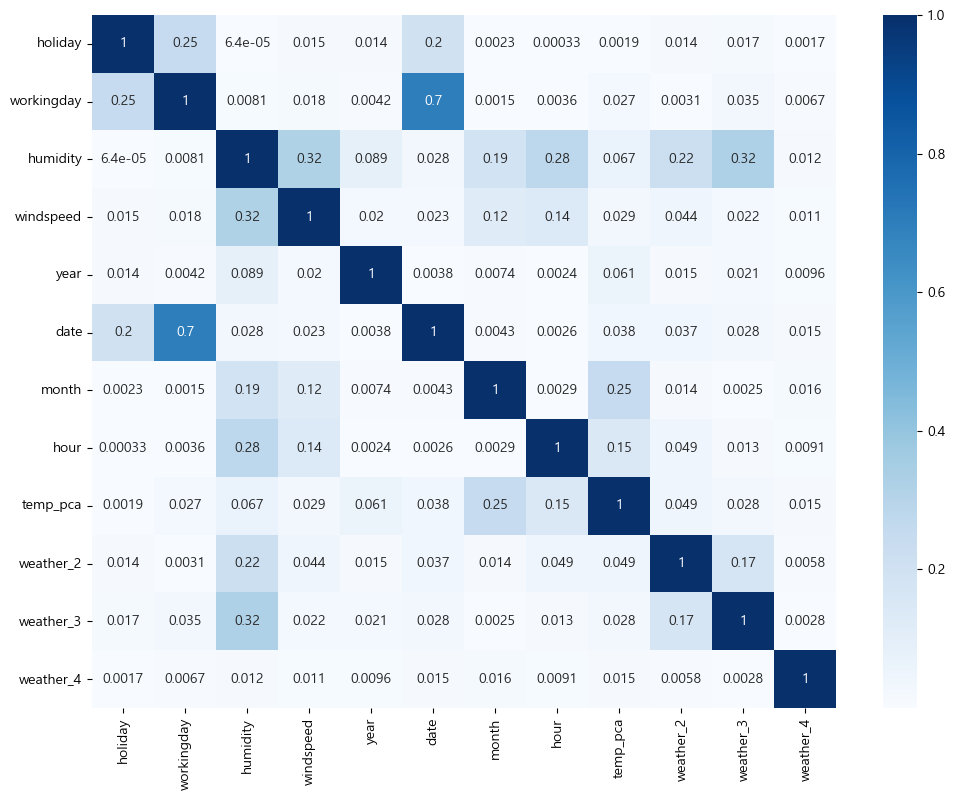

In [36]:
plt.figure(figsize=(12,9))
sns.heatmap(abs(X.corr()), annot=True, cmap='Blues')

### 2) 종속변수 구분

In [37]:
# 종속변수인 count 컬럼만 지정
y = encoded_train_df[['count']]
y.sample(3)

,count
5616,3
10534,759
422,82


## 5.2 데이터 분리
### 1) 훈련/검증데이터 분리

In [38]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# 훈련데이터 크기
print("훈련 데이터 독립변수 크기 :", len(X_train))
print("테스트 데이터 독립변수 크기 :", len(X_test))
print("훈련 데이터 종속변수 크기 :", len(y_train))
print("테스트 데이터 종속변수 크기 :", len(y_test))

훈련 데이터 독립변수 크기 : 7446
테스트 데이터 독립변수 크기 : 3192
훈련 데이터 종속변수 크기 : 7446
테스트 데이터 종속변수 크기 : 3192


## 4.4 다중 선형회귀 모델(Linear Regressor)
### 1) 기본(default) 파라미터로 모델 예측

In [40]:
from sklearn.linear_model import LinearRegression

# 다중 선형회귀 모델 정의
lr_model = LinearRegression()

# 모델 학습
lr_model.fit(X_train, y_train)

LinearRegression()

In [41]:
# 예측값 생성
lr_preds = lr_model.predict(X_test)
# 예측값 확인
lr_preds

array([[ 62.5659895 ],
       [115.97784683],
       [114.45805077],
       ...,
       [131.69241448],
       [233.71321994],
       [282.24218627]])

### 2) 예측값 확인 결과
자전거 대여량 예측값에 음수값이 존재하는 것을 확인하였다.

In [42]:
# 전체 데이터 수
print(f"전체 예측값 개수 : {len(lr_preds)}개")

# 음수값 개수 확인
print(f"음수 예측값 개수 : {(lr_preds <= 0).sum()}개")

전체 예측값 개수 : 3192개
음수 예측값 개수 : 151개


### 3) 예측값이 음수로 생성되는 이유
- 선형회귀는 예측값에 제약 조건이 없으므로, 예측값이 양수 또는 음수로 발생할 수 있다.
- 따라서 자전거 수요 예측과 같은 회귀 모델에서는 특정 제약 조건을 추가한 회귀 모델을 사용해야 한다.
    - Poision Regression (0 이상의 양수 값을 예측하는데 사용)
    - RandomForeset Regression (비선형 문제 해결에 적합)
    
#### 일단 음수 예측값이 도출된 상태로 RMSE(평균 제곱근 오차), RMSLE를 도출한다.

### 4) 검증 방법 설명
**RMSLE**는 **Root Mean Squared Logarithmic Error**의 약자로, **예측 값과 실제 값의 차이를 로그 변환하여 계산한 후, 그 차이의 제곱 평균의 제곱근을 구한 값**입니다. 이 지표는 예측 오차를 측정하는 데 사용되며, 특히 큰 값보다 **작은 값의 오차를 더 중요시하는 경우에 유용**합니다. 이는 예측 값이 실제 값보다 훨씬 클 때 더 큰 패널티를 부과하므로, 예측 값이 과대평가되는 것을 방지하는 데 효과적입니다.

RMSLE는 다음과 같이 계산됩니다:
$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(p_i + 1) - \log(a_i + 1) \right)^2}
$$


In [43]:
# 데이터프레임 형태의 y_test값을 numpy 배열 형태로 변환
y_test_lr = np.array(y_test)
y_test_lr

array([[241],
       [281],
       [499],
       ...,
       [ 19],
       [119],
       [737]], dtype=int64)

In [44]:
# 2차원 형태를 1차원으로 변경
y_test_lr = y_test_lr.ravel()
lr_preds = lr_preds.ravel()

In [45]:
# 평균 제곱근 오차 확인하기
mean_squared_error(lr_preds, y_test_lr) ** 0.5

142.91328076155844

In [46]:
# RMSLE 생성 함수
def rmsle(y_test, pred):
    # 로그 차이의 제곱 계산 (for문 없이 numpy 연산)
    log_value_sqrt = (np.log(y_test + 1) - np.log(pred + 1)) ** 2

    # 평균 후 제곱근 계산
    return np.sqrt(np.mean(log_value_sqrt))

In [47]:
# 다중선형회귀 기본 default 파라미터 RMSLE 계산
lr_rmsle_value = rmsle(y_test_lr, lr_preds)
print(f"RMSLE: {lr_rmsle_value:.4f}")

RMSLE: nan


C:\Users\gkdis\AppData\Local\Temp\ipykernel_22136\1797349077.py:4: RuntimeWarning: invalid value encountered in log
  log_value_sqrt = (np.log(y_test + 1) - np.log(pred + 1)) ** 2


#### 예측값 음수인 데이터를 전부 1로 변경한 뒤 RMSE, RMSLE 확인하기

In [48]:
# 데이터 복사
lr_preds_1 = lr_preds.copy()

# 1차원 배열 형태에서 0보다 작거나 같은 값들을 전부 1로 변환
lr_preds_1[lr_preds_1 <= 0 ] = 1

# # 예측값들의 최소값 확인
# lr_preds_1.min()

In [49]:
lr_preds_1

array([ 62.5659895 , 115.97784683, 114.45805077, ..., 131.69241448,
       233.71321994, 282.24218627])

In [50]:
lr_preds_1[lr_preds_1 <= 0] = 1

In [51]:
y_test_lr

array([241, 281, 499, ...,  19, 119, 737], dtype=int64)

In [52]:
mean_squared_error(lr_preds_1, y_test_lr) ** 0.5

142.2206209076808

In [53]:
# RMSLE 구하기
lr_rmsle_value2 = rmsle(y_test_lr, lr_preds_1)
print(f"음수값 1로 변환된 RMSLE : {lr_rmsle_value2:.4f}")

음수값 1로 변환된 RMSLE : 1.2396


## 4.5 XGBoost
### 1) XGBoost 알고리즘
XGBoost는 여러 개의 약한 결정 트리 모델을 결합하여 점점 더 나은 예측을 할 수 있도록 만들어내는 **부스팅(Boosting)** 기법의 단점을 보완한 예측&분류 알고리즘이다. 이 때, 각 단계는 이전 모델의 오차를 보완하는 방식으로 학습을 진행한다.

### 2) XGBoost default 파라미터 모델 생성 및 RMSLE 도출

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer
# XGBoost 모델 생성
xgb_model1 = xgb.XGBRegressor(objective='count:poisson', base_score=0.1, random_state=5)

# XGBoost 모델 학습
xgb_model1.fit(X_train, y_train)

XGBRegressor(base_score=0.1, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [55]:
# XGBoost 예측
xgb_pred1 = xgb_model1.predict(X_test)
 
# 성능 평가
# RMSE
print(f"XGBoost 기본 파라미터 모델 RMSE : {mean_squared_error(y_test.iloc[:, 0], xgb_pred1)**0.5:.4f}")
print(f"XGBoost 기본 파라미터 모델 RMSLE : {rmsle(y_test.iloc[:, 0], xgb_pred1):.4f}")

XGBoost 기본 파라미터 모델 RMSE : 40.0079
XGBoost 기본 파라미터 모델 RMSLE : 0.3154


In [56]:
xgb_pred1

array([235.44466  , 258.3593   , 440.60345  , ...,   7.8342514,
       121.65277  , 679.02826  ], dtype=float32)

### 3) K-Fold 교차검증 진행

In [57]:
# rmsle 점수를 계산해주는 함수 만들기
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# K의 값은 5로 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_flatten = np.array(y).flatten()
scores = cross_val_score(xgb_model1, X, y_flatten, cv=kf, scoring=rmsle_scorer)

print("각 폴드의 RMSLE", scores)
print("평균 RMSLE", np.mean(scores))

각 폴드의 RMSLE [-0.31909443 -0.28326001 -0.30658305 -0.29565374 -0.29579953]
평균 RMSLE -0.3000781510475262


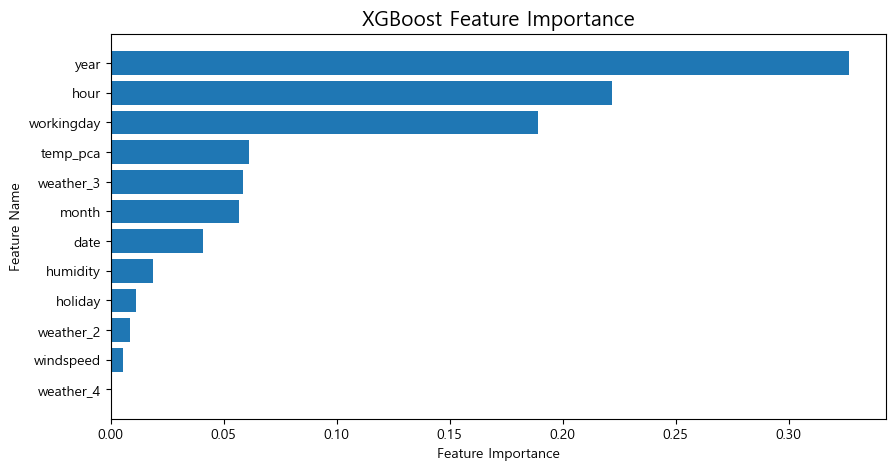

In [58]:
# XGBoost 모델 설명변수들의 중요도
importances_xgb = xgb_model1.feature_importances_
feature_names_xgb = X_train.columns

# 데이터프레임 변경
xgb_importance_df = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 바 그래프 시각화
plt.figure(figsize=(10, 5))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGBoost Feature Importance", fontsize=15)
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 설정
plt.show()

## 4.5 랜덤포레스트(RandomForest Regressor)
### 1) 랜덤포레스트 default 파라미터 모델 생성
랜덤 포레스트는 여러 개의 결정 트리를 기반으로 값을 도출하는 앙상블 모델
만약 실제값에 음수가 있다면 랜덤포레스트 모델의 예측값도 음수를 생성할 수 있다.

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
# 기본 파라미터값으로 모델 생성하여 할당
rf_model = RandomForestRegressor(random_state=5)

# 모델 학습
rf_model.fit(X_train, y_train.iloc[:, 0])

RandomForestRegressor(random_state=5)

### 2) 랜덤포레스트 예측값 도출

In [61]:
# 예측값 생성
rf_preds1 = rf_model.predict(X_test)

# 예측값 확인
rf_preds1

array([263.93, 261.63, 421.33, ...,   6.26, 118.89, 744.91])

In [62]:
# 음수값 개수 확인
print(f"음수 예측값 개수 : {(rf_preds1 <= 0).sum()}개")

음수 예측값 개수 : 0개


### 3) 실제값과 예측값 비교

In [63]:
# 평균 제곱근 오차 확인
rmse = mean_squared_error(rf_preds1, y_test) ** 0.5
print(f"평균 제곱근 오차 RMSE : {rmse:.4f}")

# 평균 제곱 오차 확인
mse = mean_squared_error(rf_preds1, y_test)
print(f"평균 제곱 오차 MSE : {mse:.4f}")

# RMSLE 확인
rf_rmsle_value1 = rmsle(np.array(y_test).ravel(), rf_preds1)
print(f"랜덤포레스트 RMSLE : {rf_rmsle_value1:.4f}")

평균 제곱근 오차 RMSE : 41.8516
평균 제곱 오차 MSE : 1751.5548
랜덤포레스트 RMSLE : 0.3476


### 4) 변수 중요도 확인

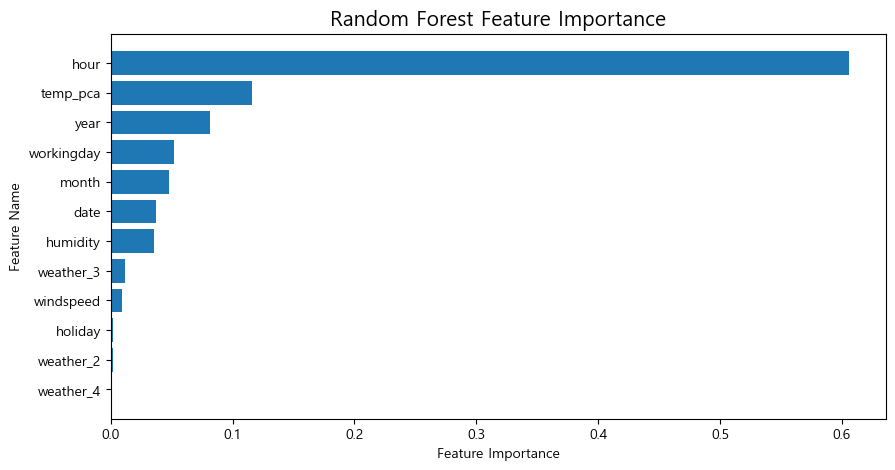

In [64]:
# 랜덤포레스트 모델 설명변수들의 중요도
importances_rf = rf_model.feature_importances_
feature_names_rf = X_train.columns

# 데이터프레임 변경
rf_importance_df = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances_rf})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 바 그래프 시각화
plt.figure(figsize=(10, 5))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importance", fontsize=15)
plt.gca().invert_yaxis()  # 중요도가 높은 것이 위로 오도록 설정
plt.show()

In [65]:
# 랜덤포레스트 변수중요도 상위 5개
rf_importance_df.head()

,Feature,Importance
7,hour,0.605593
8,temp_pca,0.116237
4,year,0.081249
1,workingday,0.051622
6,month,0.047839


C:\Users\gkdis\AppData\Local\Temp\ipykernel_22136\1896936738.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, ax=ax1, bins=50)
C:\Users\gkdis\AppData\Local\Temp\ipykernel_22136\1896936738.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rf_preds1, ax=ax2, bins=50)


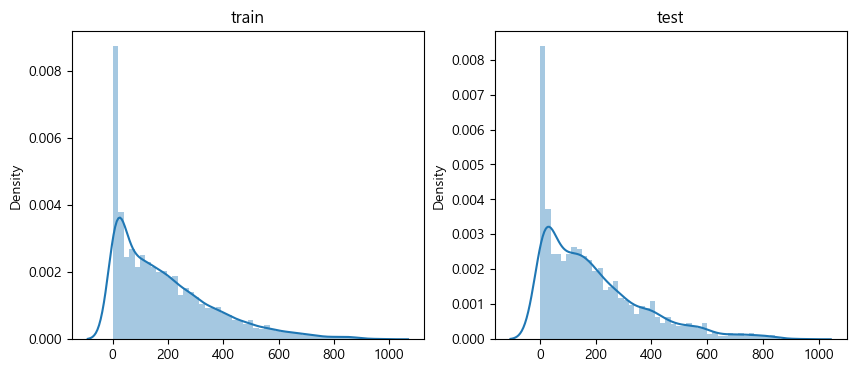

In [66]:
# 실제값과 예측값 막대그래프로 차이 비교하기
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10, 4)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(rf_preds1, ax=ax2, bins=50)
ax2.set(title='test')
plt.show()

### 5) KFold, GridSearchCV

In [67]:
# rmsle 점수를 계산해주는 함수 만들기
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# K의 값은 5로 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_flatten = np.array(y).flatten()
scores = cross_val_score(rf_model, X, y_flatten, cv=kf, scoring=rmsle_scorer)

print("각 폴드의 RMSLE", scores)
print("평균 RMSLE", np.mean(scores))

각 폴드의 RMSLE [-0.34165483 -0.30941741 -0.32401367 -0.30980042 -0.32704554]
평균 RMSLE -0.32238637433546874


In [68]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_log_error
import numpy as np

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100, 200],   # 트리 개수
    'max_depth': [None, 10, 20],      # 최대 깊이
    'min_samples_split': [2, 5, 10]   # 노드 분할 최소 샘플 수
}

# K-Fold 설정 (5개 폴드)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)  # RMSLE는 작을수록 좋음

# GridSearchCV 수행 (KFold 포함)
grid_search = GridSearchCV(
    estimator=rf_model,       # 기존 모델 사용
    param_grid=param_grid,    # 하이퍼파라미터 그리드
    scoring=rmsle_scorer,     # RMSLE 기준 평가
    cv=cv,                    # K-Fold 교차 검증
    n_jobs=-1,                # 모든 CPU 코어 사용
    verbose=2                 # 진행 상황 출력
)

# 모델 학습 (자동으로 K-Fold 수행됨)
grid_search.fit(X, y_flatten)

# 최적의 하이퍼파라미터 및 최적 성능 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적의 RMSLE 점수:", grid_search.best_score_)

# 최적의 모델 저장
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
최적의 RMSLE 점수: -0.32080855864480934


### GridSearchCV 결과
#### 랜덤포레스트 최적의 하이퍼 파라미터
- max_depth : None
- min_samples_split : 2
- n_estimators : 200
#### 랜덤포레스트 최적의 RMSLE 점수 : 0.3208

# 5. 최적의 파라미터 모델 생성
### RandomForest Regressor
- max_depth : None
- min_samples_split : 2
- n_estimators : 200

## 5.1 예측값 적용하기 

In [69]:
# 최적의 파라미터로 모델 생성
rf_model2 = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2)

# 훈련용 전체 데이터에 학습하기
rf_model2.fit(X, y.iloc[:, 0])

# 제출용 test 데이터에 예측값 적용하기
submission_predict_count = rf_model2.predict(encoded_test_df)

In [70]:
len(submission_predict_count)

6493

In [71]:
# 예측값 test 데이터에 입력하기
test_df['count'] = submission_predict_count
# 결과 확인
test_df.sample(2)
# csv 파일 저장
test_df.to_csv("test_df_2팀_고명진.csv")